In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd "/content/gdrive/My Drive/W499504_Optimization_ML/Project/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/W499504_Optimization_ML/Project


In [0]:
import os
import numpy as np
import _pickle as pickle

import torch
import torchvision
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

Define some helper functions

In [0]:
def convert(data):
    if isinstance(data, bytes):  return data.decode('ascii')
    if isinstance(data, dict):   return dict(map(convert, data.items()))
    if isinstance(data, tuple):  return map(convert, data)
    return data

def _read_data(data_path, train_files):
    images, labels = [], []
    for file_name in train_files:
        full_name = os.path.join(data_path, file_name)
        print(full_name)
        with open(full_name, mode='rb') as finp:
            data = pickle.load(finp, encoding='bytes')
            data = convert(data)
            batch_images = data["data"].astype(np.float32) / 255.0
            batch_labels = np.array(data["labels"], dtype=np.int32)
            images.append(batch_images)
            labels.append(batch_labels)
    images, labels = np.concatenate(images, axis=0), np.concatenate(labels, axis=0)
    images = np.reshape(images, [-1, 3, 32, 32])
    images = np.transpose(images, [0, 2, 3, 1])

    return images, labels


def read_data(data_path):  
    print("Read data")

    images, labels = {}, {}

    train_files = [
        "data_batch_1",
        "data_batch_2",
        "data_batch_3",
        "data_batch_4",
        "data_batch_5",
    ]
    test_file = [
        "test_batch",
    ]
    images["train"], labels["train"] = _read_data(data_path, train_files)

    images["test"], labels["test"] = _read_data(data_path, test_file)
    
    # Normalization
    print("Prepropcess: [subtract mean], [divide std]")
    mean = np.mean(images["train"], axis=(0, 1, 2), keepdims=True)
    std = np.std(images["train"], axis=(0, 1, 2), keepdims=True)

    print("mean: {}".format(np.reshape(mean * 255.0, [-1])))
    print("std: {}".format(np.reshape(std * 255.0, [-1])))

    images["train"] = (images["train"] - mean) / std
    images["test"] = (images["test"] - mean) / std
    
    labels['train'] = labels['train'].astype(np.long)

    return images, labels, mean, std
    
def plot(arrays, labels, dim, y_label):
    for arr, label in zip(arrays, labels):
        plt.plot(arr[dim], label=label)
    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel(y_label)
    plt.show()
    plt.savefig('./image_output/{}.png'.format(y_label))
    return

class LoadBatch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        dataset_size = len(self.X)
        return dataset_size
    
    def __getitem__(self, idx):
        X_batch = self.X[idx]
        y_batch = self.y[idx]
        return X_batch, y_batch

Build a train function

In [0]:
def train(train_loader, test_loader, net, optimizer, criterion, epochs, max_iter_per_epoch=None,
		  test_freq=100, istest=True, verbose=True, isStorm = True):
	train_loss_lst = []
	train_acc_lst = []
	test_acc_lst = []

	i = 0
	for epoch in range(epochs):
		for (j,data) in enumerate(train_loader,0):
			net.train()
			batch_x = data[0].cuda()
			batch_y = data[1].cuda()
			if isStorm:
				if j == 0:
					optimizer.zero_grad()
					outputs = net(batch_x)
					loss = criterion(outputs, batch_y)
					loss.backward()
					optimizer.init_step()
					continue
				optimizer.zero_grad()
				outputs = net(batch_x)
				loss = criterion(outputs, batch_y)
				loss.backward()
				optimizer.pre_step()
				
				outputs = net(batch_x)
				loss = criterion(outputs, batch_y)
				optimizer.zero_grad()
				loss.backward()
				optimizer.post_step()
			else:
				optimizer.zero_grad()
				output = net(batch_x)
				loss = criterion(output, batch_y)
				loss.backward()
				optimizer.step()

			if i % test_freq == 0:
				train_loss_lst.append(loss)
				train_acc = test(train_loader, net, optimizer, 300)      # TODO 10 -> 100
				train_acc_lst.append(train_acc)

				if istest:
					test_acc = test(test_loader, net, optimizer, 300)        # TODO 10 -> 100
					test_acc_lst.append(test_acc)
					if verbose:
						print("Epoch: {}, Batch: {}, Train Accuracy: {}, Test Accuracy: {}".format(epoch + 1, i + 1,
																								   round(float(train_acc), 3),
																								   round(float(test_acc), 3)))
				elif verbose:
					print("Epoch: {}, Batch: {}, Train Accuracy: {}".format(epoch + 1, i + 1,
																			round(float(train_acc), 3)))
	
			if max_iter_per_epoch is not None and i > max_iter_per_epoch:
				break
			i += 1

	return train_loss_lst, train_acc_lst, test_acc_lst


def test(testloader, net, optimizer, max_nb_batches):
	assert max_nb_batches > 0
	test_pred, test_target = [], []
	net.eval()
	with torch.no_grad():
		for i, data in enumerate(testloader,0):
			batch_x = data[0].cuda()
			optimizer.zero_grad()
			outputs = net(batch_x)
			_, predicted = torch.max(outputs.data, 1)

			test_pred.append(predicted.cpu().detach().numpy())
			test_target.append(data[1].cpu().detach().numpy())
			if i > max_nb_batches:
				break
		test_pred = np.concatenate(test_pred).ravel()
		test_target = np.concatenate(test_target).ravel()
	return np.mean(test_pred.astype(np.int) == test_target)


In [0]:
import torch
from typing import *
from torch.optim.optimizer import Optimizer, required

class Storm(Optimizer):
    def __init__(self, params, k=0.1, w=0.1, c=1):
        if k < 0.0:
            raise ValueError("Invalid k")
        if w < 0.0:
            raise ValueError("Invalid w")
        if c is not required and c < 0.0:
            raise ValueError("Invalid c")

        defaults = dict(k=k, w=w, c=c)
        super(Storm, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Storm, self).__setstate__(state)

    def norm(self, tensor):
        return torch.norm(tensor)

    def init_step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None: continue
                d_p = p.grad.data

                param_state = self.state[p]
                param_state['storm_d'] = torch.clone(d_p).detach()
                param_state['storm_g'] = self.norm(d_p) ** 2
        return loss

    def pre_step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            k = group['k']
            w = group['w']
            c = group['c']

            for p in group['params']:
                if p.grad is None: continue
                d_p = p.grad.data

                param_state = self.state[p]
                buf_d = param_state['storm_d']
                buf_g = param_state['storm_g']
                buf_lr = torch.div(k,torch.pow(w+buf_g,1/3) )
                param_state['storm_lr'] = buf_lr
                param_state['storm_pre_d'] = torch.clone(d_p).detach()
                # buf_lr = k / ((w + buf_g) ** (1.0 / 3.0))
                p.data.add_(-buf_lr, buf_d)
        return loss

    def post_step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            k = group['k']
            w = group['w']
            c = group['c']

            for i, p in enumerate( group['params'], 0):
                if p.grad is None: continue
                d_p = p.grad.data
                param_state = self.state[p]
                buf_d = param_state['storm_d']
                buf_g = param_state['storm_g']
                buf_pre_d = param_state['storm_pre_d']
                buf_lr = param_state['storm_lr']
                # buf_lr = k / ((w + buf_g) ** (1 / 3))
                buf_momentum = c * (buf_lr ** 2)
                buf_g.add_(self.norm(d_p) ** 2)
                if buf_momentum > 1:
                    buf_momentum = 1
                param_state['storm_d'] = d_p +  (1-buf_momentum )* (buf_d - buf_pre_d)

                if i == 0:
                    print("G: {}, lr:{}, momentum:{}".format(self.tmp(buf_g),self.tmp(buf_lr), self.tmp(buf_momentum)) )
        return loss
    
    def tmp(self, tensor):
        return tensor.cpu().detach().numpy()


def main():
    if not os.path.exists('./data/'):
        wget_cmd = 'wget https://s3-eu-west-1.amazonaws.com/bsopenbucket/e6040/data.zip'
        unzip_cmd = 'unzip data.zip'
        os.system(wget_cmd)
        os.system(unzip_cmd)
    images, labels, _, __ = read_data('data/cifar10')

    batch_size = 64

    print('Test data set shape:', images['test'].shape)
    data_train = Dataset(np.moveaxis(images['train'], 3, 1), labels['train'])
    data_test = Dataset(np.moveaxis(images['test'], 3, 1), labels['test'])
    trainloader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=2)

    criterion = nn.CrossEntropyLoss().cuda()

    def search(low, high, epsilon, call_func):
        results = [(call_func(param), param) for param in tqdm_notebook(range(low, high, epsilon))]
        return min(results, key=lambda x: x[0])[1]

    def call_storm(c):
        net = models.resnet18(pretrained=False).cuda()
        optim = Storm(net.parameters(), c=c)
        res = train(trainloader, testloader, net, optim, criterion, epochs=1, max_iter_per_epoch=500, 
                    test_freq=10, no_test=True, verbose=False)
        return sum(res[0]) / len(res[0])

    best_c = 500
    best_c = search(0, 1000, 5, call_storm)
    print('best c is: ', best_c)

    net0, net1, net2 = models.resnet18(pretrained=False).cuda(), models.resnet18(pretrained=False).cuda(), models.resnet18(pretrained=False).cuda()
    nets = [net0, net1, net2]
    isStorm = [True, False, False]
    opts = [Storm(net0.parameters(), c= best_c), torch.optim.Adam(net1.parameters()), torch.optim.Adagrad(net2.parameters())]
    file_name = ['./res18_Storm', './res18_Adam', './res18_Adagrad']
    
    for i, optim in enumerate(opts):
        print('Training Net {}'.format(file_name[i].split('_')[1]))
        res = train(trainloader, testloader, nets[i], optim, criterion, epochs=100, isStorm=isStorm[i])       # TODO epoch -> 100
        np.save(file_name[i], res)

    optim_results = []
    optim_labels = [ "Storm", "Adam", "Adagrad"]
    for name in file_name:
        name += '.npy'
        optim_results.append(np.load(name, allow_pickle = True))

    plot(optim_results, optim_labels, 0, "Loss")
    plot(optim_results, optim_labels, 1, "Train_Accuracy")
    plot(optim_results, optim_labels, 2, "Test_Accuracy")

Train the ResNet
- Optimizers:
  - Adam (default setup)
  - Adagrad (default setup)
  - Storm (To be implemneted)
- loss: Cross-entropy

In [0]:
main()

Read data
data/cifar10/data_batch_1
data/cifar10/data_batch_2
data/cifar10/data_batch_3
data/cifar10/data_batch_4
data/cifar10/data_batch_5
data/cifar10/test_batch
Prepropcess: [subtract mean], [divide std]
mean: [125.30723 122.95053 113.86535]
std: [62.993362 62.088478 66.70482 ]
Test data set shape: (10000, 32, 32, 3)


TypeError: ignored

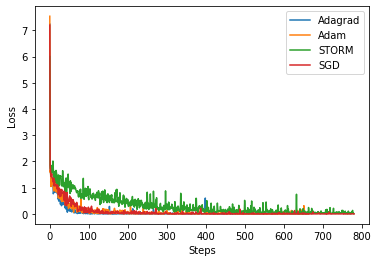

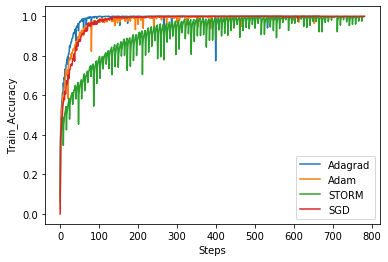

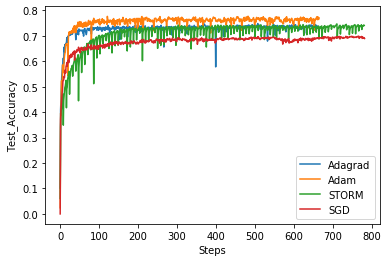

In [0]:
def plot(arrays, labels, dim, y_label):
    
    for arr, label in zip(arrays, labels):

        plt.plot(arr[dim], label=label)
    plt.legend()
    plt.xlabel("Steps")
    plt.ylabel(y_label)
    plt.show()

res_Adagrad = np.load('./res18_Adagrad_64_old.npy',allow_pickle = True)
res_Adam = np.load('./res18_Adam_64_old.npy',allow_pickle = True)
res_Storm = np.load('./res18_Storm_64.npy', allow_pickle = True)
res_SGD = np.load('./res18_SGD_64.npy', allow_pickle = True)

optim_results = [res_Adagrad, res_Adam, res_Storm, res_SGD]
optim_labels = ["Adagrad", "Adam", "STORM", "SGD"]
plot(optim_results, optim_labels, 0, "Loss")
plot(optim_results, optim_labels, 1, "Train_Accuracy")
plot(optim_results, optim_labels, 2, "Test_Accuracy")

In [0]:
main()

Read data
data/cifar10/data_batch_1
data/cifar10/data_batch_2
data/cifar10/data_batch_3
data/cifar10/data_batch_4
data/cifar10/data_batch_5
data/cifar10/test_batch
Prepropcess: [subtract mean], [divide std]
mean: [125.30723 122.95053 113.86535]
std: [62.993362 62.088478 66.70482 ]
Test data set shape: (10000, 32, 32, 3)
best c is:  30
Epoch: 1, Batch: 1, Train Accuracy: 0.034, Test Accuracy: 0.031
Epoch: 1, Batch: 101, Train Accuracy: 0.312, Test Accuracy: 0.315
Epoch: 1, Batch: 201, Train Accuracy: 0.364, Test Accuracy: 0.363
Epoch: 1, Batch: 301, Train Accuracy: 0.4, Test Accuracy: 0.396
Epoch: 1, Batch: 401, Train Accuracy: 0.425, Test Accuracy: 0.421
Epoch: 1, Batch: 501, Train Accuracy: 0.448, Test Accuracy: 0.433
Epoch: 1, Batch: 601, Train Accuracy: 0.466, Test Accuracy: 0.456
Epoch: 1, Batch: 701, Train Accuracy: 0.472, Test Accuracy: 0.457
Epoch: 2, Batch: 801, Train Accuracy: 0.332, Test Accuracy: 0.337
Epoch: 2, Batch: 901, Train Accuracy: 0.428, Test Accuracy: 0.429
Epoch: 